# Неделя Трансформеров: День 4. Спидфорс на GPU

 Когда размеры трансформеров достигли миллиардов параметров, их обучение стало стоить неприлично дорого в GPU-часах/днях/неделях... другой проблемой было то, что хотя математически все получилось у трансформеров очень красиво, на практике работа с очень длинными последовательностями оказалась затруднительной.
 
Снижение затрат на обучение архитектуры в целом, или каждого блока по отдельности приносило бы очень неплохой доход. Первой идеей было пожертвовать точностью вычислений (приближение матрицами более низкого ранга, хэширование, разреженное внимание, локальное внимание, внимание комбинир...). 

Авторы сегодняшней статьи (Стенфордский Университет, Университет Буффало, 2022) посмотрели на проблему с неожиданной стороны: как, сохраняя точность, ускориться за счет грамотного распределения вычислительных способностей видеокарты.

Исследования в этом направлении продолжаются до сих пор в топовых мировых университетах (Duke, MIT)

23 Jun 2022

Tri Daoy, Daniel Y. Fuy, Stefano Ermony, Atri Rudraz, and Christopher Réy

Department of Computer Science, Stanford University, 

Department of Computer Science and Engineering, University at Buffalo, SUNY 
(двойная аффилиация у Atri Rudraz)


FlashAttention: Fast and Memory-Efficient Exact Attention
with IO-Awareness https://arxiv.org/abs/2205.14135

Код на гитхабе: https://github.com/Dao-AILab/flash-attention

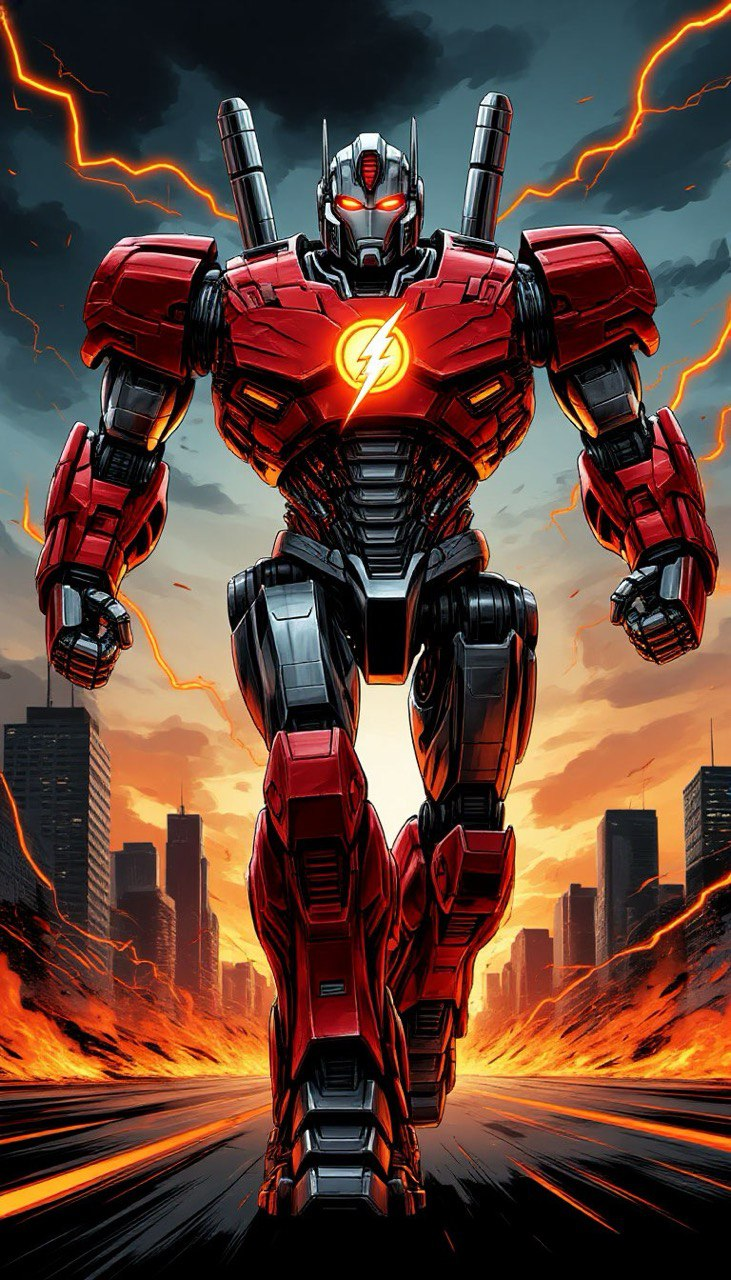

In [16]:
from IPython.display import Image
Image('4_Title.jpg', width=300, height=150 )

## Актуальность

Данная статья вышла уже три года назад, но направление по-прежнему развивается. Из последних работ (2025) на эту тему:

https://arxiv.org/abs/2508.01506 FlashSVD: Memory-Efficient Inference with Streaming for Low-Rank Models, 
Zishan Shao et all, (Duke center for computational evolutionary intelligence)

https://arxiv.org/abs/2508.18224 Flash Sparse Attention: An Alternative Efficient Implementation of Native Sparse Attention Kernel
Ran Yan et all, (The Hong Kong University of Science and Technology)

https://arxiv.org/abs/2205.14135 FlashBias: Fast Computation of Attention with Bias

Haixu Wu, Minghao Guo, Yuezhou Ma, Yuanxu Sun, Jianmin Wang,
Wojciech Matusik, Mingsheng Long 

**MIT CSAIL**, School of Software, Tsinghua University, Тайвань

    

## Основная идея

### Терминология

GPU, или графический процессор, — это компонент видеокарты, специализированный микропроцессор, предназначенный для ускорения вывода графики и выполнения параллельных вычислений, таких как рендеринг изображений, видео, анимации, а также задач машинного обучения и искусственного интеллекта.  

CUDA (Compute Unified Device Architecture) — это программно-аппаратная платформа и модель параллельных вычислений, разработанная NVIDIA, которая позволяет использовать графические процессоры (GPU) для ускорения общих вычислений, а не только для компьютерной графики.

Современные GPU имеют 2 типа памяти:

HBM — это высокопроизводительная видеопамять, обеспечивающая высокую пропускную способность для данных, необходимых GPU. 

SRAM — это быстрая кэш-память, расположенная непосредственно на чипе GPU, для доступа к данным с минимальной задержкой и сверхбыстрых вычислений. 



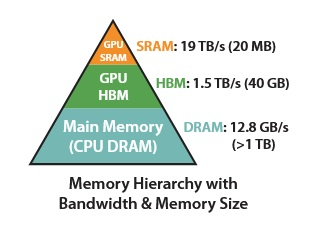

In [17]:
# рисунок из оригинальной статьи
Image('Fig_4_1.jpg', width=300, height=150 )

### Источник ускорения

Авторы заметили, что память не поспевает за вычислениями: слишком много времени уходит на передачу данных туда-сюда. В стандартной реализации матрицы Q, K, V загружаются поблочно из HBM памяти и промежуточные результаты вычислений - матрицы $S = Q K^T$ и $\mathrm{P = softmax} (S / \sqrt{d})$ - загружаются из HBM памяти в кэш и обратно. Традиционный подход, таким образом требует порядка $O(N d + N^2)$ обращений к памяти. 



Отдельным плюсом работы с матрицами является то, что их можно умножать поблочно. Входные данные - матрицы Q, K, V- нарезаются на блоки некоторого размера, такого, чтобы все влезало в SRAM. Перемножение матриц Q, K проводится поблочно (довольно древняя тема), и записывая результат в $HBM$. И ${Softmax}$, оказывается, тоже можно вычислять блок за блоком, причем достаточно дополнительно хранить сумму экспонент (нормализационный фактор) от входных данных для каждого блока и максимальное значение входов блока. 

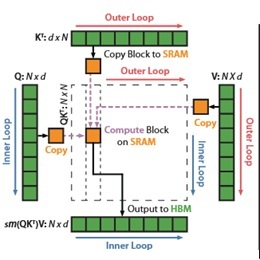

In [18]:
# рисунок из оригинальной статьи
Image('Fig_4_2.jpg', width=250, height=150 )

Итак, ключевая математическая задача статьи:

Дано: Q, K, V $\in R^{𝑁\times 𝑑}$ in HBM. Найти Attention(Q, K, V) в виде матрицы $O\in R^{𝑁\times 𝑑}$ и записать ее в HBM, максимально сократив число обращений к HBM.

Авторы используют две основных техники (Tiling, Recomputation) для решения поставленной задачи. 

1. Tiling

Это процесс разбиения подсчета Softmax на блоки и последующего склеивания их для вычисления ответа. Лучше всего немного посмотреть на формулы и осознать, как именно это происходит. 

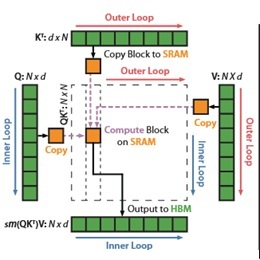

In [19]:
# Фрагмент оригинальной статьи
Image('Fig_4_2.jpg', width=250, height=150 )

Нам надо из промежуточных результатов хранить только m и l.

2. Recomputation 

При обучении нам надо проходить модель в обратном направлении. Оказывается, для этого достаточно хранить m, l и O! Строгое описание алгоритмов и все доказательства вынесены в приложение.

**Итого:** Подходящий Tiling позволяет используя одну CUDA, за один шаг загрузить данные из HBM, выполнить все операции и загрузить результаты обратно на HBM. 

Полная версия алгоритма прямого прохождения выглядит следующим образом:

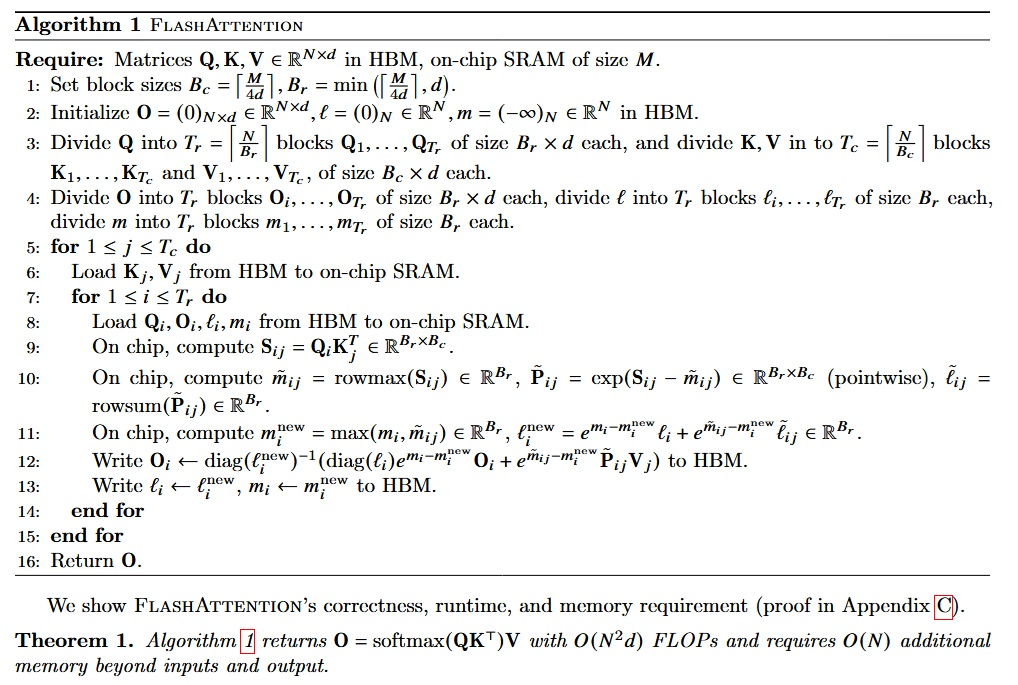

In [21]:
# Алгоритм и теорема о расходах памяти для прямого прохода
# из оригинальной статьи. Вычисление сложности обратного прохода
# вынесено в приложение статьи
Image('Fig_4_3.jpg', width=500, height=150 )

## Математика

Отдельный блок уважения авторам за то, что помимо описаний алгоритмов в виде псевдокода, они еще и математически с доказательствами оценили ускорение своей модели.

## Результаты ускорения

Чтобы добиться от модели еще лучшего результата, авторы рассмотрели возможность приближенных вычислений - дополнительную Block-Sparse модель, отбрасывая некоторые блоки вычисленной матрицы. Т. е. используя опциональную маску в Attention слое (см. день 1), зануляли часть блоков после перемножения матриц Q и K.

Авторы не просто добились значительного ускорения обучения, но еще и прибавили в качестве!

**Training Speed**. FlashAttention 

-train BERT-large (seq. length 512) 15% faster than the training speed record in MLPerf 1.1 [58], 

-GPT2 (seq. length 1K) 3x faster than baseline implementations from HuggingFace and Megatron-LM,

-long-range arena (seq. length 1K-4K) 2.4x faster than baselines.

**Quality**. FlashAttention 

-trains GPT-2 with context length 4K faster than Megatron trains GPT-2 with context length 1K, while achieving 0.7 better perplexity. Modeling longer sequences yields 6.4 points of lift on two long-
document classification tasks. 

-yields the first Transformer that can achieve
better-than-random performance on the challenging Path-X task (sequence length 16K),

-block-sparse FlashAttention yields the first sequence model that we know of that can achieve better-than-random
performance on Path-256 (sequence length 64K).

# Ссылки 

19blackadder97,  Flash attention is all you need https://habr.com/ru/articles/669506/